In [2]:
import torch
import os
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO
import pyro.distributions as dist

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

os.chdir('/Users/lucreziavaleriani/Documents/GitHub/LOCATE/')
from simulations.simulations import simulate_segment, simulate_data

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
purity = 1
coverage = 100
ploidy = 2

segs = simulate_segment(only_clonal = True, purity = purity, coverage = coverage, genome_size = 30000000)
snp,snv = simulate_data(segs)

snv = snv.loc[snv['vaf'] < 1]
take_idx = snv.index
snp = snp[snp.index.isin(take_idx)]


data_input = {'baf':torch.tensor(np.array(snp['baf']).reshape(-1, 1)), 
              'dr':torch.tensor(np.array(snp['dr']).reshape(-1, 1)),
              'vaf':torch.tensor(np.array(snv['nv']).reshape(-1, 1)),
              'dp':torch.tensor(np.array(snv['coverage']).reshape(-1, 1)),
              'dp_snp':torch.tensor(np.array(snp['cov']).reshape(-1, 1))}
print(set(snp.CN_1))

{'1:1', '2:0', '1:0'}


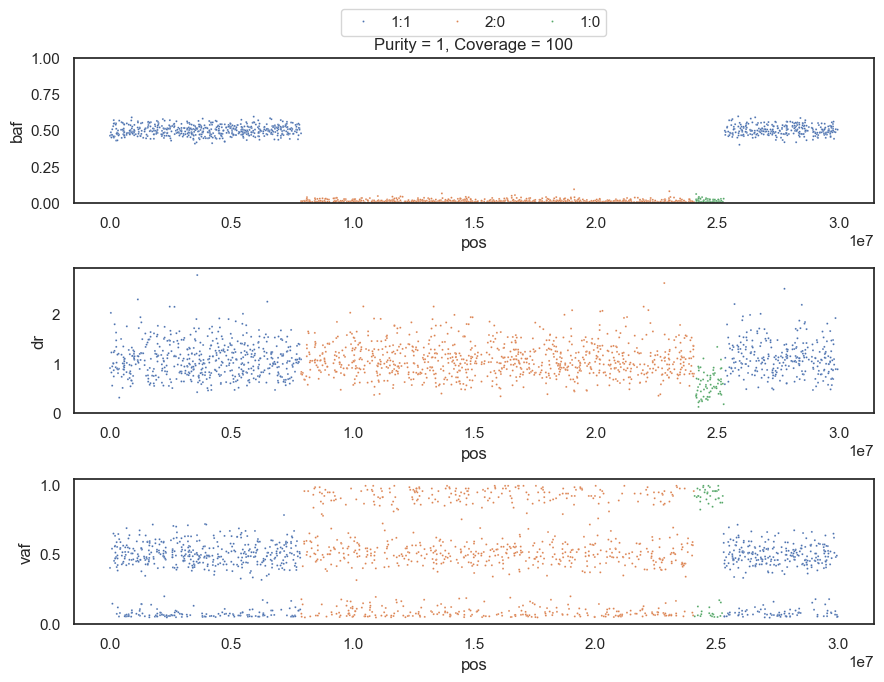

In [17]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(3, 1, figsize=(9, 7))

baf = sns.scatterplot(data=snp, x="pos", y="baf", s=2, ax=axes[0], hue="CN_1")
dr = sns.scatterplot(data=snp, x="pos", y="dr", s=2, ax=axes[1], hue="CN_1", legend=False)
vaf = sns.scatterplot(data=snv, x="pos", y="vaf", s=2, ax=axes[2], hue="CN_1", legend=False)

axes[0].set_ylim(0,1) 
sns.move_legend(
    baf, 
    "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=4, title=None, frameon=True,
)

axes[0].set_title(f'Purity = {purity}, Coverage = {coverage}')
fig.tight_layout()

In [ ]:
Major = 1
minor = 1
tot = Major+minor
cn = str(Major) + ':' + str(minor)

In [19]:
tmp_snv = snv#.loc[snv.CN_1 == cn]
vaf = torch.tensor(np.array(tmp_snv['nv']).reshape(-1, 1))
dp = torch.tensor(np.array(tmp_snv['coverage']).reshape(-1, 1))

In [ ]:
tmp_snp = snp.loc[snv.CN_1 == cn]
baf = torch.tensor(np.array(tmp_snp['baf']).reshape(-1, 1))
snp_dp = torch.tensor(np.array(tmp_snp['cov']).reshape(-1, 1))
dr = torch.tensor(np.array(tmp_snp['dr']).reshape(-1, 1))

In [ ]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(4, 1, figsize=(9, 7))

baf_p = 1
dr_p =  1
vaf_p = 1

comb = [[1,1], [1,0], [2,2], [2,0],[2,1]]
ploidy = 2
for c in comb:
    print(c)
    
    Major = c[0]
    minor = c[1]

    num = (purity * minor) +  (1 - purity)
    den = (purity * (Major + minor)) + (2 * (1 - purity))
    prob = num / den

    alpha = ((snp_dp-2) * prob + 1) / (1 - prob)       
    baf_lk = dist.Beta(concentration1 = alpha, 
                        concentration0 = snp_dp).log_prob(
        baf
        )
    axes[0].hist(baf_lk*baf_p, label=str(c), bins = 5,  histtype='step')
    

    v_dr = ((2 * (1-purity)) + (purity * (Major + minor))) / ploidy
    dr_lk = dist.Gamma(concentration = v_dr * np.sqrt(snp_dp) + 1, 
                        rate = np.sqrt(snp_dp)).log_prob(
        dr
        )
    axes[1].hist(dr_lk*dr_p, label=str(c), bins = 10, histtype='step')
    
    
    clonal_peak = get_clonal_peaks_unique(Major+minor, Major, minor, purity)
    vaf_lk = 0.0
    for p in clonal_peak:
        bin_lk = dist.Binomial(total_count = dp, 
                                        probs = torch.tensor(p),
                                ).log_prob(vaf)
        vaf_lk+= (1/len(cn)) * bin_lk
    axes[2].hist(vaf_lk*vaf_p, label=str(c), bins = 5,  histtype='step')
    
    tot_lk = baf_p * baf_lk + dr_p * dr_lk + vaf_p * vaf_lk
    axes[3].hist(tot_lk, label=str(c), bins = 5, histtype='step')
    
axes[0].set_xlabel('baf_lk')
axes[1].set_xlabel('dr_lk')
axes[2].set_xlabel('vaf_lk')
axes[3].set_xlabel('tot_lk')

plt.title(f'Correct CN = {cn}')
plt.legend()
plt.tight_layout()

In [ ]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(9, 7))


comb = [[1,1], [1,0], [2,2], [2,0],[2,1]]
ploidy = 2
for c in comb:
    print(c)
    
    Major = c[0]
    minor = c[1]

    clonal_peak = get_clonal_peaks_unique(Major+minor, Major, minor, purity)
    print(clonal_peak)

    tmp_peak = 0.0
    for p in clonal_peak:
        bin_lk = dist.Binomial(total_count = dp, 
                                        probs = torch.tensor(p),
                                ).log_prob(vaf)
        tmp_peak+= (1/len(cn)) * bin_lk
    plt.hist(tmp_peak, label=str(c), bins = 5,  histtype='step')

plt.title(f'Correct CN = {cn}')
plt.legend()
plt.tight_layout()

## Remove tail by Gaussian KDE

In [ ]:
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

In [ ]:
data = '/Users/lucreziavaleriani/Desktop/orfeo_LTS/CNA/segmentation/sim_data_races/data_races/'
sim = 'sim_1'
comb = [c for c in os.listdir(f'{data}{sim}') if c.startswith('cov')]
c = comb[-8]

data = pd.read_csv(f'{data}{sim}/{c}/mirr_smooth_snv.csv').sort_values('pos')

In [ ]:
Major = 1
minor = 1
tot = Major+minor
cn = str(Major) + ':' + str(minor)

#data = data.loc[data['vaf'] < 1]
data = data.loc[data.cna_id == cn]

data_input = {'baf':torch.tensor(np.array(data['mean_baf']).reshape(-1, 1)), 
              'dr':torch.tensor(np.array(data['mean_dr']).reshape(-1, 1)),
              'vaf':torch.tensor(np.array(data['NV']).reshape(-1, 1)),
              'dp':torch.tensor(np.array(data['DP']).reshape(-1, 1)),
              'dp_snp':torch.tensor(np.array(data['mean_dp']).reshape(-1, 1))}

In [ ]:
af = (np.array(data['NV'])/np.array(data['DP']))
kernel_adjust = 1.0  # This is the equivalent of 'adjust' in R
bandwidth = 'scott'  # Can also use 'silverman' or a specific value
kde = gaussian_kde(af, bw_method=bandwidth)

In [ ]:
np.savetxt('/Users/lucreziavaleriani/Desktop/output.csv', af, delimiter=',')

In [ ]:
plt.hist(af, bins=100)

In [ ]:
x = np.linspace(np.min(af), np.max(af), 1000)
res_kde = kde(x)
plt.plot(x, res_kde)

In [ ]:
peaks, height = find_peaks(res_kde, distance=5, height=1) 
plt.plot(res_kde)
plt.plot(peaks, res_kde[peaks], "x")
plt.plot(np.zeros_like(kde), "--", color="gray")
plt.show()

In [ ]:
df = pd.DataFrame({'x':peaks, 'y':height['peak_heights']})
df

In [ ]:
max(df.y) * (1 / 2)

In [ ]:
df.y <= max(df.y) * (1 / 2)

## Mirror VAF by purity

In [6]:
def get_clonal_peaks(tot, Major, minor, purity):
    mult = []
    for i,v in enumerate(Major):
        m = []
        if torch.equal(Major[i], minor[i]):
            m.append(Major[i][0])
        else:
            if minor[i] != 0:
                m.append(Major[i][0])
                m.append(minor[i][0])
            else:
                m.append(Major[i][0])
        if torch.equal(Major[i], torch.tensor([2])) and torch.equal(minor[i], torch.tensor([1])) == False:
            m.append(torch.tensor(1))
        mult.append(m)

    clonal_peaks = []
    for i,c in enumerate(mult):
        p = []
        for m in c:
            cp = m * purity / (tot[i] * purity + 2 * (1 - purity))
            p.append(cp)
        clonal_peaks.append(p)
        
    return clonal_peaks

In [7]:
x = torch.tensor([[0],
        [1],
        [2],
        [3],
        [4]])

tot =  torch.tensor([1, 2, 2, 3, 4])
Major = torch.tensor([1, 2, 1, 2, 2])
minor = torch.tensor([0, 0, 1, 1, 2])

purity = 1

In [10]:
clonal_peaks = get_clonal_peaks(tot[x], Major[x], minor[x], purity)
clonal_peaks

[[tensor([1.])],
 [tensor([1.]), tensor([0.5000])],
 [tensor([0.5000])],
 [tensor([0.6667]), tensor([0.3333])],
 [tensor([0.5000]), tensor([0.2500])]]

mutate(mirr_vaf = ifelse(vaf <= thr, mirr-vaf, vaf)) %>% 


In [22]:
vaf/dp <= thr

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [14]:
tmp_vaf_lk = []
for cn in clonal_peaks:
    print(cn)
    
    thr = sum(cn)/2
    mirr = sum(cn)
    
    data = 
    
    tmp_peak = 0.0
    for p in cn:
        bin_lk = dist.Binomial(total_count = dp, 
                                probs = p).log_prob(
        vaf
        )
        tmp_peak+= (1/len(cn)) * bin_lk
    tmp_vaf_lk.append(tmp_peak)
vaf_lk = torch.cat(tmp_vaf_lk, dim=1)

[tensor([1.])]
[tensor([1.]), tensor([0.5000])]
[tensor([0.5000])]
[tensor([0.6667]), tensor([0.3333])]
[tensor([0.5000]), tensor([0.2500])]
